# Практическая работа 3. Атака Carlini-Wagner (CW) на модели ИИ

Картунчиков Артем ББМО-01-23

In [114]:
import tensorflow as tf
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist


In [115]:
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0  # Normalize images to [0, 1]
test_labels = to_categorical(test_labels)  # Convert labels to one-hot encoded format

In [116]:
model = tf.keras.models.load_model('mnist_model.h5')
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy on clean images: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.9734 - loss: 0.0825
Test accuracy on clean images: 0.9776999950408936


In [117]:
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

In [118]:
attack = fb.attacks.L2CarliniWagnerAttack()

In [119]:
epsilons = np.linspace(0.01, 1, num=2)

In [120]:
image = test_images[0].reshape(1, 28, 28, 1)  # Reshape to match model input shape
label = test_labels[0]  # Get the integer label for Foolbox

In [121]:
adversarial_image = attack(fmodel, image, label, epsilons=[0.1])

ValueError: expected labels to have shape (1,), got (10,)

NameError: name 'adversarial_image' is not defined

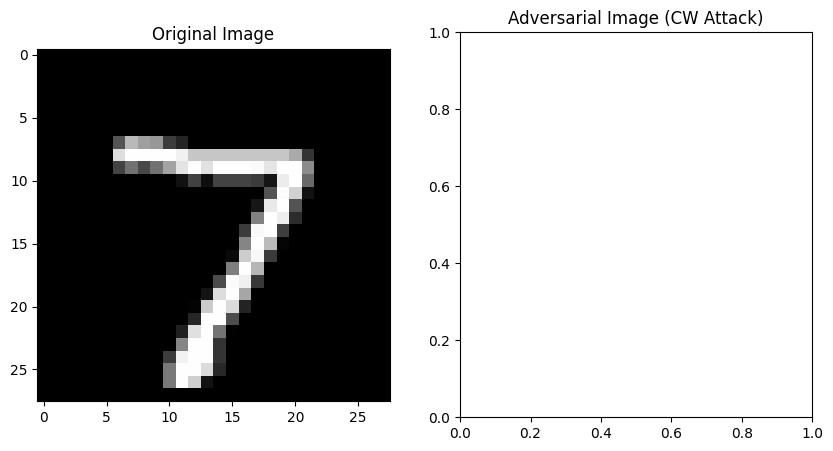

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image.reshape(28, 28), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Adversarial Image (CW Attack)")
plt.imshow(adversarial_image[0].reshape(28, 28), cmap="gray")
plt.show()


In [11]:
adversarial_images = []
for i in range(len(test_images)):
    adv_image = attack(fmodel, test_images[i].reshape(1, 28, 28, 1), int(np.argmax(test_labels[i])), epsilons=[0.1])
    adversarial_images.append(adv_image[0])

adversarial_images = np.array(adversarial_images).reshape(len(test_images), 28, 28)

# Step 10: Evaluate the model on adversarial examples

ValueError: Unknown type: <class 'int'>

In [12]:
adversarial_images = adversarial_images.reshape(len(adversarial_images), 28, 28, 1)
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f"Accuracy on adversarial examples (CW attack): {adversarial_acc}")

AttributeError: 'list' object has no attribute 'reshape'